# Shor's Algorithm: Period Finding and Factoring

**Course**: Quantum Computing Laboratory  
**Version**: 2.4  
**Last Updated**: December 2025

---

## 🔐 Breaking RSA: The Algorithm That Scared Cryptographers

## 📚 Theory

### The Problem
**Given**: Large integer N  
**Find**: Prime factors p and q where N = p × q

### Classical Complexity
- Best known: Sub-exponential
- For 2048-bit N: Billions of years

### Quantum Complexity
- **Polynomial time!**
- Feasible for large N (given enough qubits)

### Algorithm Overview
1. **Classical**: Choose random a < N
2. **Classical**: Check gcd(a, N) ≠ 1 (easy factor)
3. **Quantum**: Find period r of f(x) = a^x mod N
4. **Classical**: Use period to find factors

### Key Insight
Quantum computers excel at **period finding** → This solves factoring!

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFTGate
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import numpy as np
from math import gcd
from fractions import Fraction

print('✓ Qiskit 2.2 ready')

✓ Qiskit 2.2 ready


## 🔨 Period Finding

### Function: f(x) = a^x mod N
Find period r where f(x+r) = f(x) for all x

In [2]:
def classical_period(a, N):
    """
    Find period classically (for verification).
    
    Args:
        a: Base
        N: Modulus
    
    Returns:
        Period r
    """
    r = 1
    result = a
    while result != 1:
        result = (result * a) % N
        r += 1
    return r

# Example: a=7, N=15
a, N = 7, 15
r_classical = classical_period(a, N)
print(f'Classical period finding:')
print(f'  a={a}, N={N}')
print(f'  Period r = {r_classical}')
print(f'\nVerification:')
for x in range(6):
    print(f'  f({x}) = {a}^{x} mod {N} = {pow(a, x, N)}')

Classical period finding:
  a=7, N=15
  Period r = 4

Verification:
  f(0) = 7^0 mod 15 = 1
  f(1) = 7^1 mod 15 = 7
  f(2) = 7^2 mod 15 = 4
  f(3) = 7^3 mod 15 = 13
  f(4) = 7^4 mod 15 = 1
  f(5) = 7^5 mod 15 = 7


## 🎯 Quantum Period Finding: The Deep Connection to Phase Estimation

Shor's algorithm is fundamentally an application of **Quantum Phase Estimation (QPE)**. Understanding this connection is crucial for grasping why the circuit has its particular structure.

### The Modular Multiplication Operator

We define the unitary operator $U$ that performs multiplication by $a$ modulo $N$:

$$U|y\rangle = |ay \mod N\rangle$$

This operator is unitary because multiplication by $a$ (when $\gcd(a,N)=1$) is a permutation of the integers $\{0, 1, ..., N-1\}$.

### Eigenstates of U

The key insight is that $U$ has eigenstates of the form:

$$|u_s\rangle = \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} e^{-2\pi i sk/r} |a^k \mod N\rangle$$

where $s \in \{0, 1, ..., r-1\}$ and $r$ is the period we seek.

### Eigenvalues Encode the Period!

When $U$ acts on these eigenstates:

$$U|u_s\rangle = e^{2\pi i s/r}|u_s\rangle$$

The eigenvalue is $e^{2\pi i s/r}$, so the **phase is $s/r$**. If we can measure this phase, we can extract $r$ from the denominator!

### Why Powers of 2?

Phase Estimation requires applying controlled-$U^{2^q}$ operations. Here's why:

Each counting qubit $q$ controls $U^{2^q}$:

```
qubit 0  ──●──  controls U^1   = U^(2^0)
qubit 1  ──●──  controls U^2   = U^(2^1)
qubit 2  ──●──  controls U^4   = U^(2^2)
qubit 3  ──●──  controls U^8   = U^(2^3)
  ...
qubit 7  ──●──  controls U^128 = U^(2^7)
```

After the Hadamard gates, each counting qubit is in $|+\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$.

When controlled-$U^{2^q}$ acts on an eigenstate $|u_s\rangle$:

$$|0\rangle|u_s\rangle \rightarrow |0\rangle|u_s\rangle$$
$$|1\rangle|u_s\rangle \rightarrow e^{2\pi i \cdot 2^q \cdot s/r}|1\rangle|u_s\rangle$$

So qubit $q$ accumulates a phase of $2^q \cdot (s/r)$.

### The Complete Picture

After all controlled-$U$ operations, the counting register contains:

$$\frac{1}{2^{n/2}} \sum_{x=0}^{2^n-1} e^{2\pi i x \cdot s/r}|x\rangle$$

This is exactly the state that the **inverse QFT** transforms into a sharp peak at $|\tilde{x}\rangle$ where:

$$\tilde{x} \approx 2^n \cdot \frac{s}{r}$$

### Binary Phase Encoding

The powers of 2 encode the phase bit-by-bit:
- Qubit 0 → least significant bit of the phase
- Qubit 1 → second bit
- ...
- Qubit n-1 → most significant bit

The inverse QFT then "reads out" this binary-encoded phase into a measurable computational basis state.

### Circuit Structure
1. Counting register (n qubits) - for phase estimation
2. Working register (m qubits) - stores $|a^x \mod N\rangle$
3. Controlled modular exponentiation: encodes phase information
4. Inverse QFT on counting register: extracts phase
5. Measure → Extract period from continued fractions

In [3]:
def c_amod15(a, power):
    """
    Controlled multiplication by a^power mod 15.
    
    This implements U^power where U|y⟩ = |ay mod 15⟩.
    Simplified implementation for N=15 using SWAP gates.
    
    Args:
        a: Base (must be coprime to 15)
        power: Exponent (typically 2^q for phase estimation)
    
    Returns:
        Controlled gate implementing a^power mod 15
    """
    if a not in [2, 4, 7, 8, 11, 13]:
        raise ValueError("'a' must be coprime to 15")
    
    U = QuantumCircuit(4)
    
    for _ in range(power):
        if a in [2, 13]:
            U.swap(0, 1)
            U.swap(1, 2)
            U.swap(2, 3)
        if a in [7, 8]:
            U.swap(2, 3)
            U.swap(1, 2)
            U.swap(0, 1)
        if a in [4, 11]:
            U.swap(1, 3)
            U.swap(0, 2)
        if a in [7, 11, 13]:
            for q in range(4):
                U.x(q)
    
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

print('✓ Modular exponentiation gate defined')

✓ Modular exponentiation gate defined


### Build Shor Circuit

In [4]:
def shor_circuit(a, N=15, n_count=8):
    """
    Shor's algorithm circuit for factoring N=15.
    
    The circuit implements Quantum Phase Estimation to find
    eigenvalues of the modular multiplication operator U.
    
    Args:
        a: Base (coprime to N)
        N: Number to factor
        n_count: Number of counting qubits (precision)
    
    Returns:
        QuantumCircuit implementing Shor's algorithm
    """
    cr = ClassicalRegister(n_count, 'meas')
    qr = QuantumRegister(n_count + 4)
    qc = QuantumCircuit(qr, cr)
    
    # Step 1: Initialize counting qubits in superposition
    # Creates: (1/√2^n) Σ|x⟩ for x = 0 to 2^n - 1
    for q in range(n_count):
        qc.h(q)
    
    # Step 2: Initialize working register to |1⟩
    # This is important: |1⟩ = Σ|u_s⟩ (superposition of all eigenstates)
    qc.x(n_count)
    
    qc.barrier(label='Init')
    
    # Step 3: Apply controlled-U^(2^q) operations
    # Each qubit q controls U^(2^q), encoding phase information
    # This is the heart of Phase Estimation
    for q in range(n_count):
        qc.append(c_amod15(a, 2**q), [q] + list(range(n_count, n_count + 4)))
    
    qc.barrier(label='Mod Exp')
    
    # Step 4: Apply inverse QFT to extract phase
    # Transforms phase-encoded state into computational basis
    qc.append(QFTGate(n_count).inverse(), range(n_count))
    
    qc.barrier(label='IQFT')
    
    # Step 5: Measure counting register
    qc.measure(range(n_count), range(n_count))
    
    return qc

Shor circuit for a=7, N=15:
  Depth: 11
  Size: 26


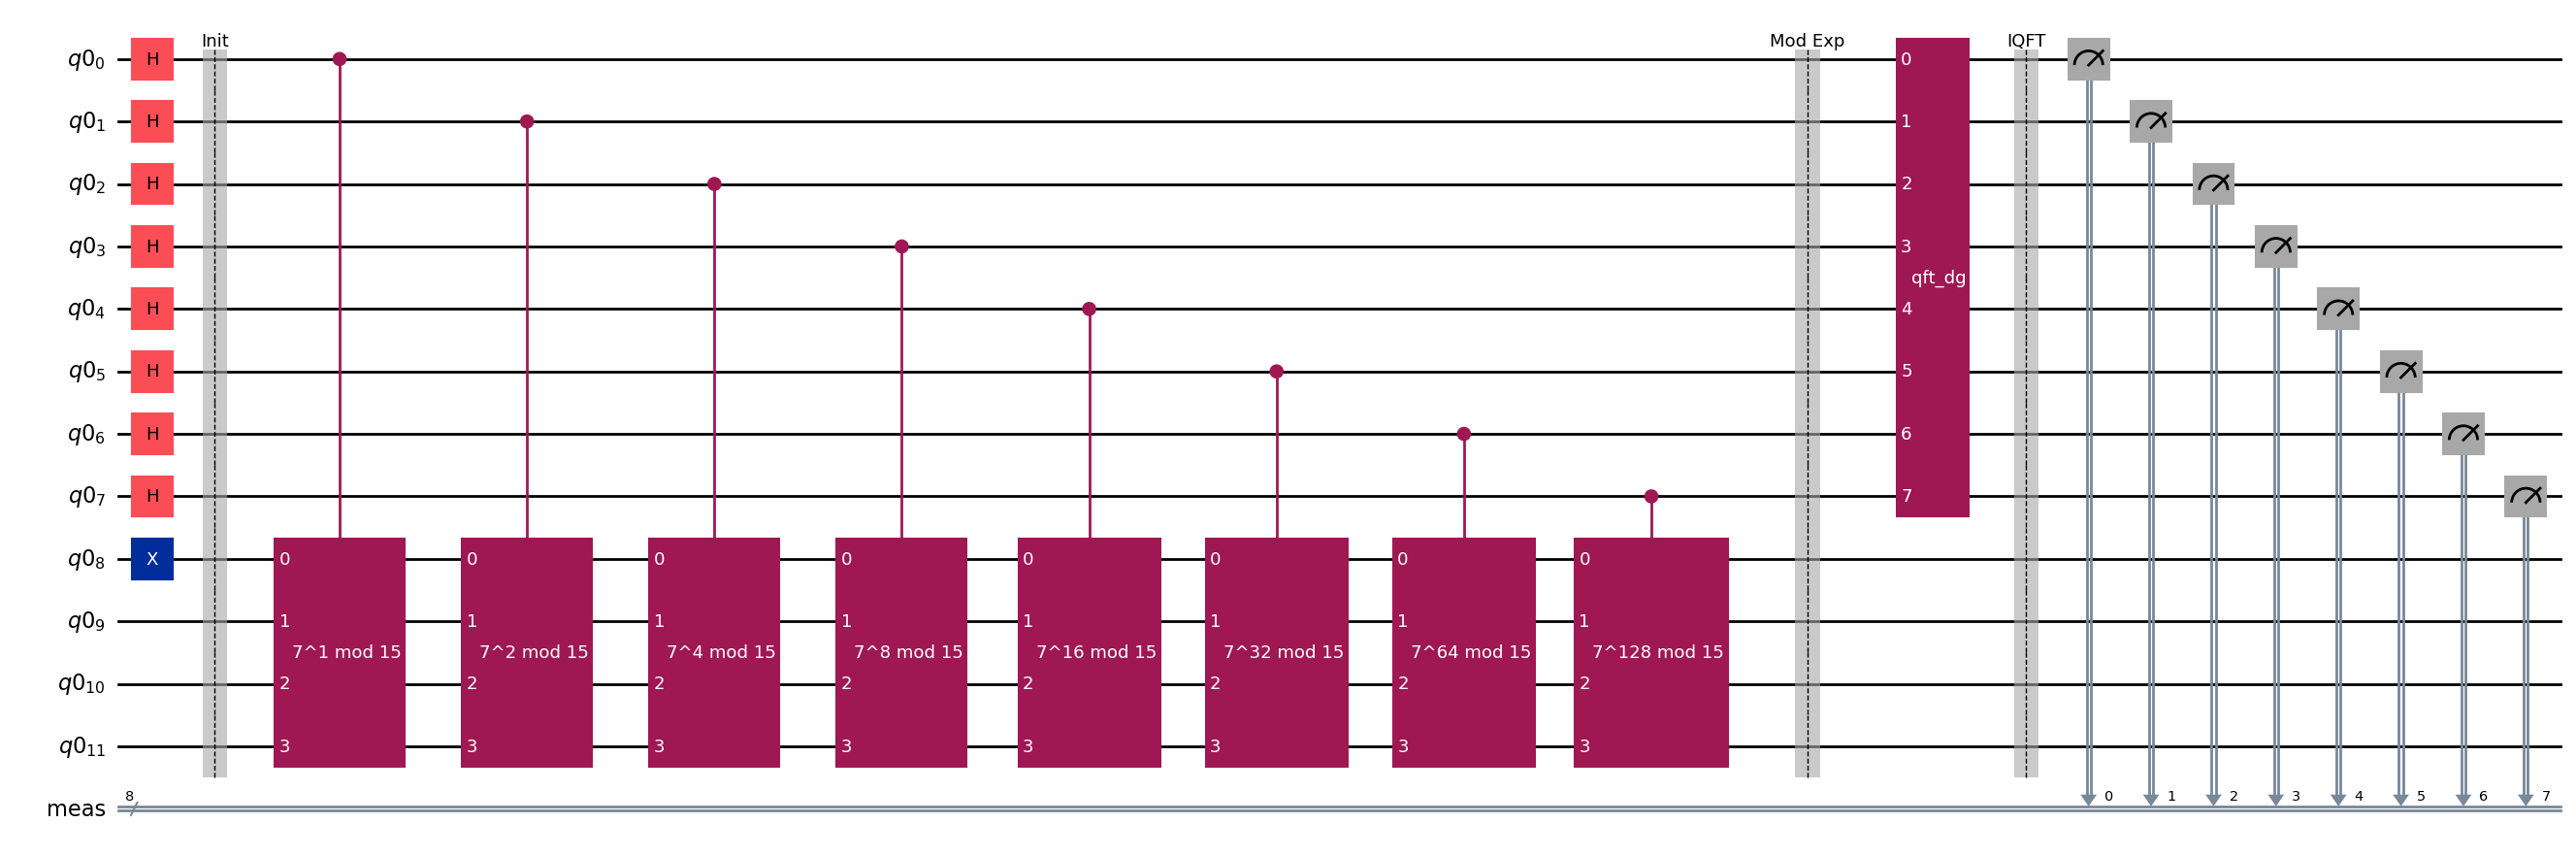

In [5]:
# Create circuit for a=7, N=15
a_shor = 7
N_shor = 15
qc_shor = shor_circuit(a_shor, N_shor)
print(f'Shor circuit for a={a_shor}, N={N_shor}:')
print(f'  Depth: {qc_shor.depth()}')
print(f'  Size: {qc_shor.size()}')
qc_shor.draw('mpl', fold=-1)

### Execute and Find Period

In [6]:
simulator = AerSimulator()
sampler = SamplerV2()
pm = generate_preset_pass_manager(optimization_level=1, backend=simulator)
transpiled = pm.run(qc_shor)

job = sampler.run([transpiled], shots=2048)
result = job.result()
counts = result[0].data.meas.get_counts()

print('Top measurement results:')
for bitstring, count in sorted(counts.items(), key=lambda x: -x[1])[:8]:
    decimal = int(bitstring, 2)
    phase = decimal / (2**8)
    print(f'  |{bitstring}⟩ → {decimal} → phase ≈ {phase:.4f} | Count: {count}')

Top measurement results:
  |11000000⟩ → 192 → phase ≈ 0.7500 | Count: 547
  |01000000⟩ → 64 → phase ≈ 0.2500 | Count: 532
  |10000000⟩ → 128 → phase ≈ 0.5000 | Count: 504
  |00000000⟩ → 0 → phase ≈ 0.0000 | Count: 465


### Understanding the Measurement Results

For a=7, N=15, the period is r=4. The eigenvalues of U are $e^{2\pi i s/4}$ for s=0,1,2,3.

With 8 counting qubits (2^8 = 256), we expect peaks at:

| s | Phase s/r | Expected value 256·(s/r) | Binary |
|---|-----------|--------------------------|--------|
| 0 | 0/4 = 0.00 | 0 | 00000000 |
| 1 | 1/4 = 0.25 | 64 | 01000000 |
| 2 | 2/4 = 0.50 | 128 | 10000000 |
| 3 | 3/4 = 0.75 | 192 | 11000000 |

These four peaks correspond to the four eigenstates $|u_0\rangle, |u_1\rangle, |u_2\rangle, |u_3\rangle$.

## 🔢 Extracting the Period: The Continued Fractions Algorithm

After measurement, we obtain an integer $m$ between 0 and $2^n - 1$. This value is related to the phase by:

$$m \approx 2^n \cdot \frac{s}{r}$$

where $s$ is a random integer in $\{0, 1, ..., r-1\}$ and $r$ is the period we seek.

**The Problem**: We know $m$ and $n$, we need to find $r$. But the measurement only gives us an *approximation* of $s/r$, not the exact fraction!

### Why Do We Need a Sophisticated Method?

Suppose we measure $m = 64$ with $n = 8$ qubits. We compute:

$$\frac{m}{2^n} = \frac{64}{256} = 0.25$$

Now, 0.25 could represent many fractions:
- 1/4 → r = 4
- 2/8 → r = 8  
- 25/100 → r = 100
- 64/256 → r = 256

Which denominator is correct? Intuitively, we want the **smallest denominator** that approximates the measured value well, because $r$ is typically small compared to $2^n$.

### Continued Fractions: The Key Idea

Continued fractions represent a real number as a sequence of increasingly precise "floors":

$$x = a_0 + \cfrac{1}{a_1 + \cfrac{1}{a_2 + \cfrac{1}{a_3 + \cdots}}}$$

Compact notation: $x = [a_0; a_1, a_2, a_3, ...]$

**Fundamental Property**: The convergents (truncations of the continued fraction) are the **best rational approximations** with bounded denominators.

### The Key Theorem

**Theorem**: If $|x - s/r| < 1/(2r^2)$ and $r < N$, then $s/r$ is a convergent of the continued fraction expansion of $x$.

In our case:
- QPE guarantees that $m/2^n$ approximates $s/r$ with error $< 1/2^n$
- If $2^n > 2r^2$, the error is sufficiently small
- Therefore $s/r$ **must** appear among the convergents!

**Choice of n**: This is why we use $n \approx 2\log_2(N)$ counting qubits, ensuring $2^n > N^2 > r^2$.

### Detailed Example: m = 65, n = 8 (Imperfect Measurement)

Suppose we measure $m = 65$ instead of 64 (1-bit error):

$$\frac{65}{256} = 0.25390625$$

**Computing the Continued Fraction of 65/256**:

| Step | Value | Integer Part | Inverse of Remainder |
|------|-------|--------------|----------------------|
| 0 | 0.2539... | 0 | 3.938... |
| 1 | 3.938... | 3 | 1.066... |
| 2 | 1.066... | 1 | 15.2 |
| 3 | 15.2 | 15 | 5 |
| 4 | 5 | 5 | - |

So: $65/256 = [0; 3, 1, 15, 5]$

**Computing Convergents**:

| Index | Continued Fraction | Convergent | Denominator |
|-------|-------------------|------------|-------------|
| 0 | [0] | 0/1 | 1 |
| 1 | [0; 3] | 1/3 | 3 |
| 2 | [0; 3, 1] | 1/4 | 4 |
| 3 | [0; 3, 1, 15] | 16/63 | 63 |
| 4 | [0; 3, 1, 15, 5] | 65/256 | 256 |

The convergent 1/4 has denominator $r = 4$, which is the correct period!

### Which Convergent is Correct? Classical Verification!

**Important**: We cannot know *a priori* which convergent gives the correct period just from the measurement. We must **verify classically** each candidate.

The complete algorithm is:

```
For each convergent with denominator r_candidate:
    1. Test if a^(r_candidate) ≡ 1 (mod N)
    2. If yes → this is the period (or a divisor of it)
    3. If no  → try the next convergent
```

This classical verification is efficient: computing $a^r \mod N$ takes $O(\log r)$ multiplications using fast exponentiation.

In [7]:
def get_convergents(numerator, denominator):
    """
    Compute all convergents of a fraction using continued fractions.
    
    The convergents are the best rational approximations with
    denominators up to each successive bound.
    
    Args:
        numerator: Numerator of the fraction
        denominator: Denominator of the fraction
    
    Returns:
        List of (numerator, denominator) tuples for each convergent
    """
    convergents = []
    
    # Build continued fraction coefficients [a_0; a_1, a_2, ...]
    coeffs = []
    n, d = numerator, denominator
    while d != 0:
        q = n // d          # Integer part
        coeffs.append(q)
        n, d = d, n - q * d  # Remainder and swap
    
    # Compute convergents using recurrence relation:
    # h_k = a_k * h_{k-1} + h_{k-2}
    # k_k = a_k * k_{k-1} + k_{k-2}
    h_prev, h_curr = 1, coeffs[0]
    k_prev, k_curr = 0, 1
    convergents.append((h_curr, k_curr))
    
    for i in range(1, len(coeffs)):
        h_new = coeffs[i] * h_curr + h_prev
        k_new = coeffs[i] * k_curr + k_prev
        convergents.append((h_new, k_new))
        h_prev, h_curr = h_curr, h_new
        k_prev, k_curr = k_curr, k_new
    
    return convergents, coeffs

# Demonstrate with our example
print("Continued fraction expansion of 65/256:")
print("="*50)
convergents, coeffs = get_convergents(65, 256)
print(f"Coefficients: [{coeffs[0]}; {', '.join(map(str, coeffs[1:]))}]")
print(f"\nConvergents:")
for i, (num, den) in enumerate(convergents):
    print(f"  c_{i} = {num}/{den} = {num/den:.6f}")

Continued fraction expansion of 65/256:
Coefficients: [0; 3, 1, 15, 4]

Convergents:
  c_0 = 0/1 = 0.000000
  c_1 = 1/3 = 0.333333
  c_2 = 1/4 = 0.250000
  c_3 = 16/63 = 0.253968
  c_4 = 65/256 = 0.253906


In [8]:
def find_period_from_measurement(m, n_qubits, a, N):
    """
    Extract period by testing all convergent denominators.
    
    This is the complete classical post-processing step that
    takes a measurement outcome and finds the period.
    
    Args:
        m: Measured integer from counting register
        n_qubits: Number of counting qubits
        a: Base for modular exponentiation
        N: Number to factor
    
    Returns:
        Period r, or None if not found
    """
    if m == 0:
        return None, "m=0 gives no information"
    
    # Get all convergents of m / 2^n
    convergents, coeffs = get_convergents(m, 2**n_qubits)
    
    print(f"  Measured m={m}, phase = {m}/{2**n_qubits} = {m/2**n_qubits:.6f}")
    print(f"  Continued fraction: [{coeffs[0]}; {', '.join(map(str, coeffs[1:]))}]")
    print(f"  Convergents: {convergents}")
    print(f"  Testing denominators:")
    
    # Test each denominator as a candidate period
    for num, denom in convergents:
        if denom == 0 or denom > N:
            continue
        
        # Classical verification: check if a^denom ≡ 1 (mod N)
        result = pow(a, denom, N)
        if result == 1:
            print(f"    r={denom}: {a}^{denom} mod {N} = 1  ✓ FOUND!")
            return denom, "success"
        else:
            print(f"    r={denom}: {a}^{denom} mod {N} = {result}  ✗")
    
    return None, "no valid period found"

# Test with different measurements
print("="*60)
print("PERIOD EXTRACTION FROM MEASUREMENTS")
print("="*60)
print(f"Parameters: a={a_shor}, N={N_shor}, expected period r={r_classical}")
print()

test_measurements = [64, 65, 128, 192]
for m in test_measurements:
    print(f"\n{'─'*60}")
    print(f"Measurement m = {m}:")
    r, status = find_period_from_measurement(m, 8, a_shor, N_shor)
    print(f"  → Result: r = {r} ({status})")

PERIOD EXTRACTION FROM MEASUREMENTS
Parameters: a=7, N=15, expected period r=4


────────────────────────────────────────────────────────────
Measurement m = 64:
  Measured m=64, phase = 64/256 = 0.250000
  Continued fraction: [0; 4]
  Convergents: [(0, 1), (1, 4)]
  Testing denominators:
    r=1: 7^1 mod 15 = 7  ✗
    r=4: 7^4 mod 15 = 1  ✓ FOUND!
  → Result: r = 4 (success)

────────────────────────────────────────────────────────────
Measurement m = 65:
  Measured m=65, phase = 65/256 = 0.253906
  Continued fraction: [0; 3, 1, 15, 4]
  Convergents: [(0, 1), (1, 3), (1, 4), (16, 63), (65, 256)]
  Testing denominators:
    r=1: 7^1 mod 15 = 7  ✗
    r=3: 7^3 mod 15 = 13  ✗
    r=4: 7^4 mod 15 = 1  ✓ FOUND!
  → Result: r = 4 (success)

────────────────────────────────────────────────────────────
Measurement m = 128:
  Measured m=128, phase = 128/256 = 0.500000
  Continued fraction: [0; 2]
  Convergents: [(0, 1), (1, 2)]
  Testing denominators:
    r=1: 7^1 mod 15 = 7  ✗
    r=2: 7^2 mo

### What Can Go Wrong?

#### Case 1: m = 128 Fails!

The phase 0.5 = 1/2 gives denominator r = 2, but $7^2 \mod 15 = 4 \neq 1$.

This happens because:
- The true phase is $s/r = 2/4 = 1/2$
- The convergent gives $r = 2$, which is a **divisor** of the true period $r = 4$

**Solutions**:
1. Try multiples: if $r$ doesn't work, try $2r$, $3r$, ...
2. Repeat the algorithm and combine results using LCM
3. Use more measurements and look for patterns

#### Case 2: gcd(s, r) > 1

If $s$ and $r$ share a common factor $g$, the continued fraction gives $r/g$ instead of $r$.

Example: True phase = 2/4 = 1/2 → we get r = 2 instead of r = 4

#### Case 3: m = 0

Measurement $m = 0$ corresponds to phase 0, which gives no information about $r$. Simply discard and repeat.

In [9]:
def find_period_robust(m, n_qubits, a, N, max_multiplier=5):
    """
    Robust period finding that handles divisors of the true period.
    
    If a candidate r doesn't work, also tries multiples 2r, 3r, etc.
    
    Args:
        m: Measured integer
        n_qubits: Number of counting qubits
        a: Base
        N: Number to factor
        max_multiplier: Maximum multiple to try
    
    Returns:
        Period r or None
    """
    if m == 0:
        return None
    
    convergents, _ = get_convergents(m, 2**n_qubits)
    
    for num, denom in convergents:
        if denom == 0 or denom > N:
            continue
        
        # Try the denominator and its small multiples
        for mult in range(1, max_multiplier + 1):
            r_candidate = denom * mult
            if r_candidate > N:
                break
            if pow(a, r_candidate, N) == 1:
                return r_candidate
    
    return None

# Test the robust version
print("\nRobust period finding (trying multiples):")
print("="*50)
for m in [64, 65, 128, 192]:
    r = find_period_robust(m, 8, a_shor, N_shor)
    print(f"  m={m:3d} → r = {r}")


Robust period finding (trying multiples):
  m= 64 → r = 4
  m= 65 → r = 4
  m=128 → r = 4
  m=192 → r = 4


### Apply to Actual Quantum Results

In [10]:
print("\nAnalyzing actual measurement results:")
print("="*60)

periods_found = {}

for bitstring, count in sorted(counts.items(), key=lambda x: -x[1]):
    m = int(bitstring, 2)
    r = find_period_robust(m, 8, a_shor, N_shor)
    
    if r:
        if r not in periods_found:
            periods_found[r] = 0
        periods_found[r] += count

print("\nPeriod statistics from quantum measurement:")
for r, cnt in sorted(periods_found.items(), key=lambda x: -x[1]):
    print(f"  r = {r}: {cnt} counts ({100*cnt/2048:.1f}%)")

print(f"\nExpected period: {r_classical}")


Analyzing actual measurement results:

Period statistics from quantum measurement:
  r = 4: 1583 counts (77.3%)

Expected period: 4


### Visual Summary of the Extraction Process

```
Measurement: m = 65 (with n=8 qubits)
         ↓
Raw phase: 65/256 = 0.25390625
         ↓
Continued fraction: [0; 3, 1, 15, 5]
         ↓
Convergents: 0/1, 1/3, 1/4, 16/63, 65/256
         ↓
Test denominators:
    r=1: 7^1 mod 15 = 7  ✗
    r=3: 7^3 mod 15 = 13 ✗
    r=4: 7^4 mod 15 = 1  ✓ FOUND!
         ↓
Period r = 4
         ↓
Verify: 7^4 mod 15 = 2401 mod 15 = 1 ✓
```

## 🔓 Factor N Using Period

### Classical Post-processing
Given period r:
1. If r is odd, try again
2. If a^(r/2) ≡ -1 (mod N), try again  
3. Otherwise: gcd(a^(r/2) ± 1, N) gives factors!

### Why This Works

Since $a^r \equiv 1 \pmod{N}$, we have:

$$a^r - 1 \equiv 0 \pmod{N}$$

If r is even, we can factor:

$$(a^{r/2} - 1)(a^{r/2} + 1) \equiv 0 \pmod{N}$$

Unless $a^{r/2} \equiv \pm 1 \pmod{N}$, both factors share non-trivial common factors with N.

In [11]:
def factor_from_period(a, r, N):
    """
    Extract factors of N from the period r.
    
    Uses the relation: (a^(r/2) - 1)(a^(r/2) + 1) ≡ 0 (mod N)
    
    Args:
        a: Base used in period finding
        r: Period found
        N: Number to factor
    
    Returns:
        Tuple (factor1, factor2) or (None, None) if unsuccessful
    """
    if r % 2 == 1:
        return None, None  # Period is odd
    
    # Check a^(r/2) ≠ -1 (mod N)
    x = pow(a, r // 2, N)
    if x == N - 1:
        return None, None
    
    # Compute factors using gcd
    factor1 = gcd(x + 1, N)
    factor2 = gcd(x - 1, N)
    
    return factor1, factor2

# Try to factor N=15 using the periods found
print(f'\nFactoring N={N_shor} using a={a_shor}:')
print(f'Periods found: {list(periods_found.keys())}')

for r in sorted(periods_found.keys(), key=lambda x: -periods_found[x])[:3]:
    f1, f2 = factor_from_period(a_shor, r, N_shor)
    if f1 and f1 != 1 and f1 != N_shor:
        print(f'\n  ✓ Period r={r} → Factors: {f1} and {f2}')
        print(f'    Verification: {f1} × {f2} = {f1 * f2}')
        break
    else:
        x = pow(a_shor, r // 2, N_shor) if r % 2 == 0 else None
        print(f'  Period r={r}: ', end='')
        if r % 2 == 1:
            print('Failed (r is odd)')
        elif x == N_shor - 1:
            print(f'Failed (a^(r/2) = {x} ≡ -1 mod {N_shor})')
        else:
            print(f'Failed (trivial factors)')


Factoring N=15 using a=7:
Periods found: [4]

  ✓ Period r=4 → Factors: 5 and 3
    Verification: 5 × 3 = 15


### Detailed Factorization Example

Let's trace through the factorization step by step:

In [12]:
# Step-by-step factorization
print(f'Factoring N={N_shor} with a={a_shor}, period r={r_classical}')
print('='*50)

r = r_classical
print(f'\n1. Check if r={r} is even: {"Yes" if r % 2 == 0 else "No"}')

x = pow(a_shor, r // 2, N_shor)
print(f'\n2. Compute x = a^(r/2) mod N = {a_shor}^{r//2} mod {N_shor} = {x}')

print(f'\n3. Check x ≠ N-1: {x} ≠ {N_shor-1}? {"Yes" if x != N_shor-1 else "No"}')

print(f'\n4. Compute factors:')
print(f'   gcd(x+1, N) = gcd({x+1}, {N_shor}) = {gcd(x+1, N_shor)}')
print(f'   gcd(x-1, N) = gcd({x-1}, {N_shor}) = {gcd(x-1, N_shor)}')

f1 = gcd(x+1, N_shor)
f2 = gcd(x-1, N_shor)
print(f'\n5. Result: {N_shor} = {f1} × {f2} ✓')

Factoring N=15 with a=7, period r=4

1. Check if r=4 is even: Yes

2. Compute x = a^(r/2) mod N = 7^2 mod 15 = 4

3. Check x ≠ N-1: 4 ≠ 14? Yes

4. Compute factors:
   gcd(x+1, N) = gcd(5, 15) = 5
   gcd(x-1, N) = gcd(3, 15) = 3

5. Result: 15 = 5 × 3 ✓


## 📊 Summary

### The Complete Algorithm Flow

```
Input: N=15, a=7
    ↓
[Quantum] Hadamard → Controlled-U^(2^q) → Inverse QFT → Measure
    ↓
Measured value: m (e.g., 65)
    ↓
[Classical] Continued fractions of m/2^n → Convergents
    ↓
[Classical] Test each convergent denominator: a^r mod N = 1?
    ↓
Period found: r = 4
    ↓
[Classical] gcd(a^(r/2) ± 1, N) → Factors: 3 and 5
```

### Complexity Comparison
| Method | Time Complexity |
|--------|----------------|
| Trial Division | O(√N) |
| General Number Field Sieve | sub-exponential |
| **Shor's Algorithm** | **O((log N)³)** |

### For RSA-2048
- Classical: ~10^9 years
- Quantum (Shor): Hours with sufficient qubits!

### Requirements
- ~2n qubits for n-bit number
- High-fidelity gates
- Error correction

## 🎓 Exercises

### Exercise 1: Different Base (Easy)
Run Shor for a=11, N=15. Compare period found.

### Exercise 2: Factor 21 (Medium)
Implement simplified Shor for N=21, a=2.

### Exercise 3: Analysis (Hard)
Calculate qubit requirements for factoring RSA-2048.

### Exercise 4: Phase Estimation Deep Dive (Medium)
Verify that the eigenstates $|u_s\rangle$ satisfy $U|u_s\rangle = e^{2\pi i s/r}|u_s\rangle$ for a=7, N=15.

### Exercise 5: Continued Fractions (Medium)
Compute the continued fraction expansion of 85/256 by hand and identify which convergent gives the correct period for a=7, N=15.

## 📖 References

1. Shor, P. (1997). *Polynomial-Time Algorithms for Prime Factorization and Discrete Logarithms on a Quantum Computer*. SIAM J. Comput. 26(5), 1484-1509.
2. Nielsen & Chuang, *Quantum Computation and Quantum Information*, Section 5.3
3. Qiskit Textbook: https://learn.qiskit.org/course/ch-algorithms/shors-algorithm
4. Hardy & Wright, *An Introduction to the Theory of Numbers*, Chapter 10 (Continued Fractions)

---

**Version**: 2.4.0  
**License**: MIT